# DBSCAN - UBER DRIVER ASSISTENT (UDA)

### Import packages

In [1]:
import matplotlib.pyplot as plt
import os 

import math
import pandas as pd
import numpy as np

from collections import Counter
from sklearn import metrics
from datetime import datetime

from sklearn.metrics import accuracy_score,confusion_matrix


from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.manifold import TSNE
# from sklearn.datasets.samples_generator import make_blobs


import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")


In [2]:
def get_labels(df):
    y = df.iloc[:,-1:]
    y= y.values.reshape(-1, 1)
    return (y)
    
def clean_data(df):
    scaler = StandardScaler() 
    df = df.dropna()
    df = df.reset_index(drop=True)
    df = df.iloc[:,:-1]
    
    X = df.values.reshape(-1, df.shape[1])
#     X = scaler.fit_transform(X) 
    y = get_labels(df)

    if X.shape[1]>2:
        df_temp = pd.DataFrame([])
        if 'pickup_centroid_latitude' and 'pickup_centroid_longitude' in df.columns:
            x_axis = df['pickup_centroid_latitude']
            x_axis = pd.DataFrame(x_axis)
            x_axis['pickup_centroid_longitude'] = df['pickup_centroid_longitude']
            X_embedded = TSNE(n_components=1).fit_transform(x_axis)
            df['x_axis']= X_embedded
            df = df.drop(['pickup_centroid_latitude','pickup_centroid_longitude' ],axis = 1)
            X = pd.DataFrame(df)
            X = X.values.reshape(-1, X.shape[1])
            X = scaler.fit_transform(X) 




        if 'dropoff_centroid_latitude' and 'dropoff_centroid_longitude' in df.columns:
                y_axis = df['dropoff_centroid_latitude']
                y_axis = pd.DataFrame(y_axis)
                y_axis['dropoff_centroid_longitude'] = df['dropoff_centroid_longitude']
                X_embedded = TSNE(n_components=1).fit_transform(y_axis)
                df['y_axis']=X_embedded
                df = df.drop(['dropoff_centroid_latitude','dropoff_centroid_longitude' ],axis = 1)
                X = pd.DataFrame(df)
                X = X.values.reshape(-1, X.shape[1])
                X = scaler.fit_transform(X) 

        

        X_embedded = TSNE(n_components=2).fit_transform(X)
        X = X_embedded
        
    X = scaler.fit_transform(X)        # Normalize
    return (X,y)



In [3]:
def generate_labels(data,n_clusters):

    df = pd.DataFrame(data)
    df.sort_values(by=[0], inplace=True)
    if n_clusters == 0:
        return 
    cluster_size = len(data)/n_clusters
    cluster_size = int (cluster_size)
    dfs = []
    for i in range(n_clusters):
        low = (i)*cluster_size
        high = (i+1)*cluster_size
        if i == 0:  
            df_1 = df.iloc[:high,:] 
        if i == n_clusters-1: 
            df_1 = df.iloc[low:,:] 
        else:
            df_1 = df.iloc[low:high,:] 
        dfs.append(df_1)
    df_all = pd.DataFrame([])
    for i in range(len(dfs)):
        df = dfs[i]
        df_ = df[0]
        df["true_label"] = [i] * len(df_)
        df_all = df_all.append(df) #     print(dfs)
    df_all = df_all.sort_index(axis = 0) #     print(df_all)
    return(df_all["true_label"])

In [4]:
def find_params(X,ns):

#     plt.scatter(X[:,0], X[:,1])
    neigh = NearestNeighbors(n_neighbors=ns)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)


    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
#     print(distances)

    

In [5]:
# import seaborn as sns

def Graph_v1(X,n):
    print ("Graph Before Clustering")
    x_axis = X[:,0]
    y_axis = X[:,1]

    # Plot Points
    plt.scatter(x_axis,y_axis)
    plt.savefig(n)

    plt.show()

def Graph_v2(X_train,labels,core_samples_mask,n_clusters_,name):
    print ("Graph After Clustering")

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
#     sns.set_style('white')
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X_train[class_member_mask & core_samples_mask]
#         print(class_member_mask)
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.savefig(name)

    plt.show()
    
# Graph(X_train,lables, core_samples_mask,n_clusters_)

In [6]:



def DBSCAN_(X,labels_true,ep,min_samples):
#     X_train, X_test = train_test_split(X, test_size=0.30)
    X_train = X
    db = DBSCAN(ep, min_samples).fit(X_train)
#     print(db)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
#     print(labels)
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
#     labels_true = labels_true.flatten() 

#     print(X_train,labels_true)
#     print(len(labels_true), len(labels),n_clusters_)
    labels_true = generate_labels(true_label,n_clusters_) 
#     print(labels_true)
    print(len(labels_true), len(labels))
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Print clusters number of clusters:',  Counter(labels))
    print('Estimated number of noise points: %d' % n_noise_)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    print("Adjusted Rand Index: %0.3f"
          % metrics.adjusted_rand_score(labels_true, labels))
    print("Adjusted Mutual Information: %0.3f"
          % metrics.adjusted_mutual_info_score(labels_true, labels))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X_train, labels))
    
    return (X_train,core_samples_mask,labels,n_clusters_)
    # make a df with all of this data
    
    


In [7]:
# Read all of the labels and trip-totals
# Compute a Range and mean for each label 
# put this in a df and output it. 
# When the client is given a cluster he can now see what price to expect 


   
Number of Data Points:  3000
Number of Data Points:  ['pickup_centroid_latitude', 'pickup_centroid_longitude', 'trip_total']
2798 2798
Estimated number of clusters: 2
Print clusters number of clusters: Counter({0: 2729, 1: 69})
Estimated number of noise points: 0
Homogeneity: 0.025
Completeness: 0.150
V-measure: 0.043
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.043
Silhouette Coefficient: 0.679
Graph Before Clustering


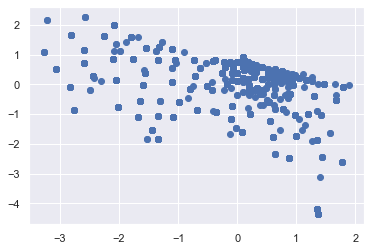

Graph After Clustering


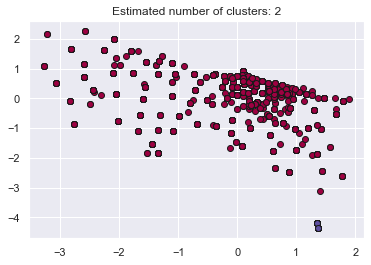

Number of Data Points:  ['dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'trip_total']
2743 2743
Estimated number of clusters: 2
Print clusters number of clusters: Counter({0: 2736, 1: 7})
Estimated number of noise points: 0
Homogeneity: 0.003
Completeness: 0.100
V-measure: 0.005
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.004
Silhouette Coefficient: 0.680
Graph Before Clustering


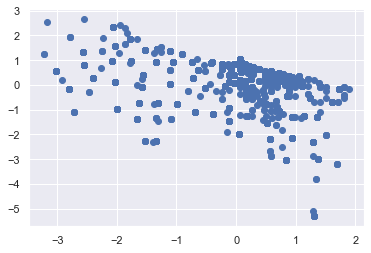

Graph After Clustering


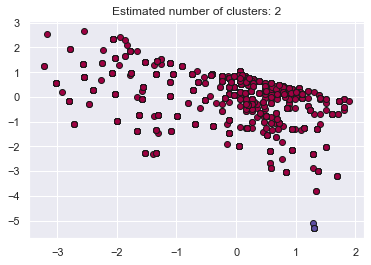

Number of Data Points:  ['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'trip_total']
2536 2536
Estimated number of clusters: 32
Print clusters number of clusters: Counter({-1: 1022, 21: 76, 1: 67, 18: 64, 13: 64, 16: 64, 10: 58, 20: 57, 4: 55, 19: 54, 7: 54, 28: 54, 11: 48, 9: 47, 17: 47, 3: 44, 23: 43, 30: 43, 15: 42, 22: 42, 0: 40, 26: 40, 2: 39, 14: 39, 5: 39, 27: 39, 6: 39, 25: 39, 8: 38, 29: 36, 12: 35, 24: 35, 31: 33})
Estimated number of noise points: 1022
Homogeneity: 0.293
Completeness: 0.372
V-measure: 0.328
Adjusted Rand Index: 0.025
Adjusted Mutual Information: 0.275
Silhouette Coefficient: 0.130
Graph Before Clustering


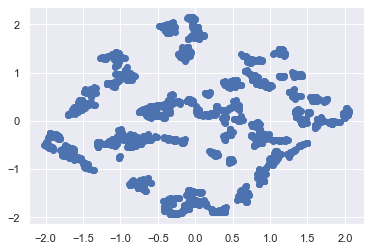

Graph After Clustering


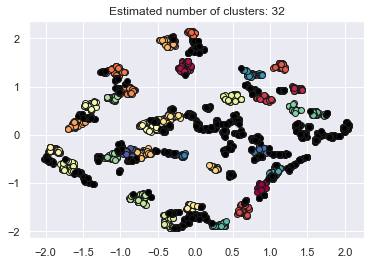

   
Number of Data Points:  4000
Number of Data Points:  ['pickup_centroid_latitude', 'pickup_centroid_longitude', 'trip_total']
3709 3709
Estimated number of clusters: 2
Print clusters number of clusters: Counter({0: 3618, 1: 91})
Estimated number of noise points: 0
Homogeneity: 0.025
Completeness: 0.150
V-measure: 0.043
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.043
Silhouette Coefficient: 0.678
Graph Before Clustering


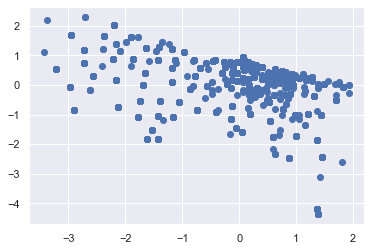

Graph After Clustering


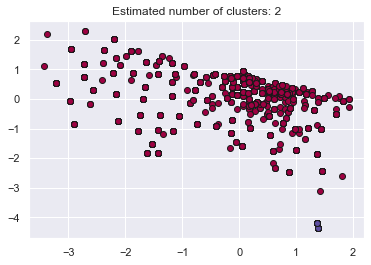

Number of Data Points:  ['dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'trip_total']
3685 3685
Estimated number of clusters: 2
Print clusters number of clusters: Counter({0: 3671, 1: 14})
Estimated number of noise points: 0
Homogeneity: 0.004
Completeness: 0.106
V-measure: 0.007
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.007
Silhouette Coefficient: 0.682
Graph Before Clustering


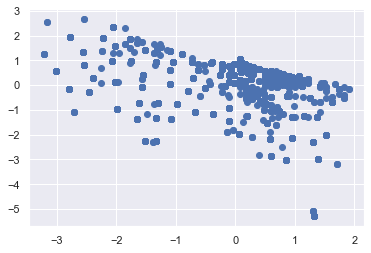

Graph After Clustering


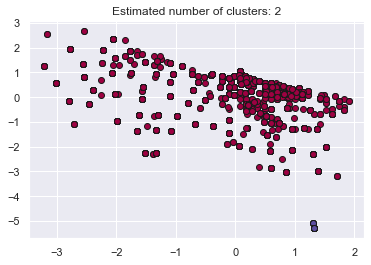

Number of Data Points:  ['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'trip_total']
3354 3354
Estimated number of clusters: 52
Print clusters number of clusters: Counter({-1: 736, 6: 124, 0: 96, 11: 88, 12: 88, 13: 75, 1: 70, 19: 70, 8: 69, 4: 68, 28: 66, 2: 65, 24: 65, 9: 64, 25: 63, 32: 62, 23: 62, 3: 60, 7: 56, 15: 53, 26: 51, 36: 49, 16: 48, 37: 48, 39: 45, 31: 45, 30: 44, 17: 43, 46: 43, 29: 43, 5: 41, 33: 41, 10: 40, 34: 40, 50: 40, 35: 40, 45: 39, 27: 37, 22: 37, 38: 37, 14: 35, 18: 35, 41: 35, 48: 35, 47: 35, 44: 35, 42: 34, 21: 33, 51: 33, 43: 27, 20: 25, 49: 24, 40: 17})
Estimated number of noise points: 736
Homogeneity: 0.390
Completeness: 0.433
V-measure: 0.410
Adjusted Rand Index: 0.053
Adjusted Mutual Information: 0.331
Silhouette Coefficient: 0.301
Graph Before Clustering


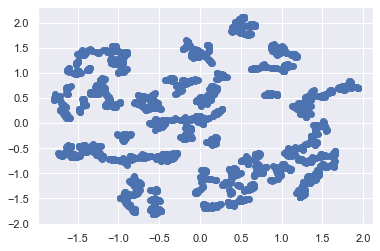

Graph After Clustering


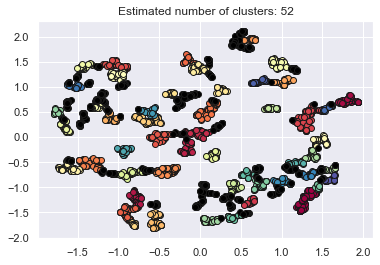

   
Number of Data Points:  5000
Number of Data Points:  ['pickup_centroid_latitude', 'pickup_centroid_longitude', 'trip_total']
4653 4653
Estimated number of clusters: 2
Print clusters number of clusters: Counter({0: 4551, 1: 102})
Estimated number of noise points: 0
Homogeneity: 0.022
Completeness: 0.147
V-measure: 0.039
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.038
Silhouette Coefficient: 0.677
Graph Before Clustering


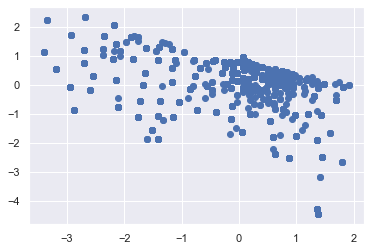

Graph After Clustering


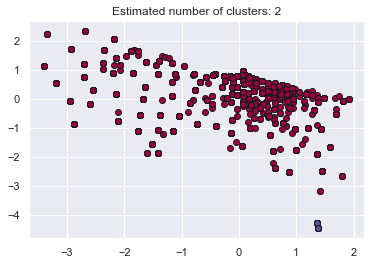

Number of Data Points:  ['dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'trip_total']
4588 4588
Estimated number of clusters: 2
Print clusters number of clusters: Counter({0: 4570, 1: 18})
Estimated number of noise points: 0
Homogeneity: 0.004
Completeness: 0.106
V-measure: 0.008
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.007
Silhouette Coefficient: 0.671
Graph Before Clustering


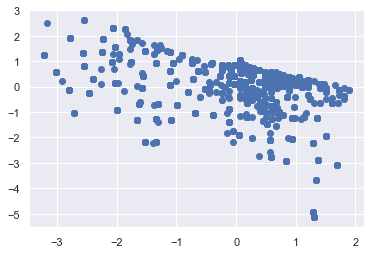

Graph After Clustering


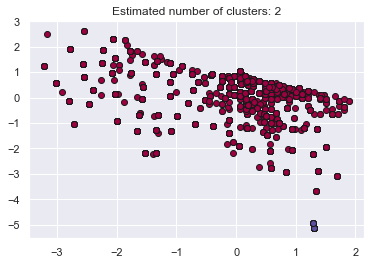

Number of Data Points:  ['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'trip_total']
4268 4268
Estimated number of clusters: 11
Print clusters number of clusters: Counter({-1: 3591, 6: 84, 3: 70, 7: 68, 0: 65, 8: 58, 2: 58, 10: 58, 9: 56, 5: 56, 1: 52, 4: 52})
Estimated number of noise points: 3591
Homogeneity: 0.085
Completeness: 0.250
V-measure: 0.127
Adjusted Rand Index: 0.005
Adjusted Mutual Information: 0.119
Silhouette Coefficient: -0.395
Graph Before Clustering


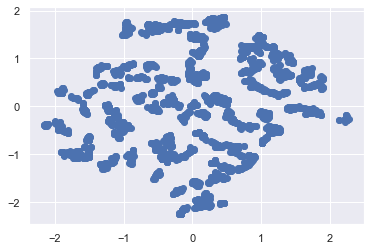

Graph After Clustering


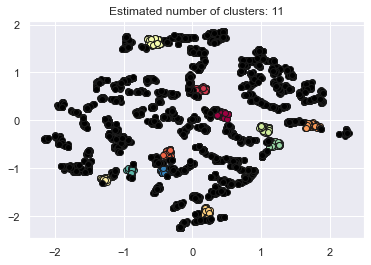

In [8]:



def find_eps(X_train):
    results = []
    min_samples = 8
    for min_sample in range(2,min_samples):
        min_sample = min_sample 
        for i in range(1,10):
            ep =  (i/10)
            db = DBSCAN(ep, min_sample).fit(X_train)
            labels = db.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters_ == 0:
                pass
#                 print(n_clusters_)
            if n_clusters_ == 1:
                pass
        
            else: 
                labels_true = generate_labels(true_label,n_clusters_) 
                results.append([min_sample,ep,n_clusters_,metrics.silhouette_score(X_train, labels)])

    df = pd.DataFrame(results)
    return df

if __name__ == "__main__" :
        times = []
        sizes = [3000,4000,5000]
#         sizes = [3000]

        uber_df = pd.read_csv('data/uber_data_010.csv')
 
        dfs = [['pickup_centroid_latitude','pickup_centroid_longitude',"trip_total" ],
               ['dropoff_centroid_latitude','dropoff_centroid_longitude',"trip_total" ],
               ['pickup_centroid_latitude','pickup_centroid_longitude', 'dropoff_centroid_latitude', "dropoff_centroid_longitude","trip_total" ]]

# find_params
        for size in sizes:
            print ("   ")
            print ("Number of Data Points: ",size)

            for i in range(len(dfs)): 
                dff = dfs[i]
                name = str(size) + str(i) + '_original.png'
                name_1 = str(size) + str(i) + '_cluster.png'
                name = (os.path.join("data/" ,name)) 
                name_1 = (os.path.join("data/", name_1)) 

                start=datetime.now()
                df = uber_df.sample(n = size) 
                df = df[dff]
                print ("Number of Data Points: ",list(df.columns.values))

                X,true_label = clean_data(df)  

                #                 print ("Fetures: ",list(X))

                df = find_eps(X)
                eps = df[1][df[3].argmax()]
                min_samples = df[2][df[3].argmax()]
            
                X_train,core_samples_mask,lables,n_clusters_= DBSCAN_(X,true_label,eps, min_samples)
                stop_time = datetime.now()-start
                
                times.append([size,dff,eps,min_samples, stop_time])
                Graph_v1(X,name)

                Graph_v2(X_train,lables, core_samples_mask,n_clusters_,name_1)
                

                #         Graph_v1(X)
                #         Graph_v2(X_train,lables, core_samples_mask,n_clusters_)




                

#         print (datetime.now()-start)



In [9]:
pd.DataFrame(times, olumns = ['Size', 'Fetures', "Run Time", 'eps','MinPt'])

TypeError: __init__() got an unexpected keyword argument 'olumns'

In [10]:
df = pd.DataFrame(times, columns = ['Size', 'Fetures', 'eps','MinPt',"Run Time"])

rows = []
for row in df.values:
    row = row[4].seconds
    rows.append(row)
rows

df["Run Time"] = rows
df.to_csv("data/Results.csv", index = False)
df

,Size,Fetures,eps,MinPt,Run Time
0,3000,"[pickup_centroid_latitude, pickup_centroid_lon...",0.8,2,9
1,3000,"[dropoff_centroid_latitude, dropoff_centroid_l...",0.9,2,8
2,3000,"[pickup_centroid_latitude, pickup_centroid_lon...",0.1,34,24
3,4000,"[pickup_centroid_latitude, pickup_centroid_lon...",0.8,2,15
4,4000,"[dropoff_centroid_latitude, dropoff_centroid_l...",0.9,2,14
5,4000,"[pickup_centroid_latitude, pickup_centroid_lon...",0.1,33,30
6,5000,"[pickup_centroid_latitude, pickup_centroid_lon...",0.8,2,25
7,5000,"[dropoff_centroid_latitude, dropoff_centroid_l...",0.9,2,24
8,5000,"[pickup_centroid_latitude, pickup_centroid_lon...",0.1,52,42


In [ ]:
print(str(stop_time.time()))
df.MinPt

In [ ]:
# df_3
stop_time

In [ ]:



# plt.plot(distances)

# m = DBSCAN(eps=0.3, min_samples=5)
# m.fit(X)

In [ ]:
plt.plot(distances)